### Instructions / References

**OLS/WLS NUMPY COLUMN REFERENCE:**
* 0 - ('time_stamp', np.int64),                   # the timestamp for the event
* 1 - ('baseline', np.int16),                     # the baseline for the event
* 2 - ('peak', np.int16),                         # the peak energy value for the event
* 3 - ('energy', np.int32),                       # the sum of the energy values for the event
* 4 - ('noise', np.int16),                        # the estimated noise floor for the event
* 5 - ('timeOver', np.double),                    # timeOver(Threshold)
* 6 - ('timeOverType', np.byte),                  # type (G,N,U) as determined by the timeOver(Threshold) method
* 7 - ('riseTime', np.double),                    # riseTime
* 8 - ('riseTimeType', np.byte),                  # type (G,N,U) as determined by the riseTime method
* 9 - ('qRatio', np.double),                      # qRatio
* 10 - ('qRatioType', np.byte),                    # type (G,N,U) as determined by the qRatio method
* 11 - ('values', np.int16, (self.eventLength,)),  # flipped, relative to baseline, band filtered
* 12 - ('based', np.int16, (self.eventLength,)),   # flipped, relative to baseline, not band filter
* 13 - ('raw', np.int16, (self.eventLength,))      # flipped, but otherwise unmodified values

### Setup / Pre-processing

In [ ]:
# general imports
import os
import sys
import io
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, Normalizer
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Dense, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras.optimizers import RMSprop

# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

# filepath for project folder
path = '/content/drive/My Drive/RESEARCH/NG_DISCRIMINATION/'

# to play sound when cell finishes executing
from IPython.display import Audio
sound_file = path + 'wow.mp3'

Mounted at /content/drive


In [ ]:
ols = np.load(path + 'datasets/202002192353/ols.npy')
wls = np.load(path + 'datasets/202002192353/wls.npy')
print(ols.shape, wls.shape)

(178255,) (178255,)


In [ ]:
# determine peak threshold for dataset
peaks = []
for i in range(len(wls)):
  peaks.append(wls[i][2])
pMax = max(peaks)
pMin = min(peaks)
threshold = pMin + .18 * (pMax - pMin)
print("Dataset Threshold:",threshold)

# extract sequences & labels iff pulse peak > threshold
seqs = []
labels = []
for i in range(len(wls)):
  if wls[i][2] > threshold:
    seqs.append(wls[i][11])
    if ols[i][10] == 1:
        labels.append(0)
    elif ols[i][10] == 2:
        labels.append(1)
seqs = np.array(seqs)
seqs = seqs.astype('float64')
labels = np.array(labels)
print(seqs.shape, labels.shape)

Dataset Threshold: 26.82
(177360, 150) (177360,)


In [1]:
#@title SHOW OLD CODE

# # extract sequences
# limit = len(wls) # to define size of subset
# seqs = []
# for i in range(limit):
#     seqs.append(wls[i][11])
# seqs = np.array(seqs)
# seqs = seqs.astype('float64')
# print(seqs)
# seqs.shape

In [ ]:
#@title SHOW OLD CODE

# OLD

# # extract labels (1 = G, 2 = N, converted to 0 & 1 for training, respectively)
# labels = []
# for i in range(limit):
#     if ols[i][10] == 1:
#         labels.append(0)
#     elif ols[i][10] == 2:
#         labels.append(1)
# labels = np.array(labels)
# print(labels)
# labels.shape

In [ ]:
# split into training & test sets
xtrain, xtest, ytrain, ytest = train_test_split(seqs, labels, test_size = .2, shuffle = True, random_state = 8)

print(xtrain.shape, ytrain.shape, xtest.shape, ytest.shape)

(141888, 150) (141888,) (35472, 150) (35472,)


In [ ]:
# normalize training sequences
normalizer = Normalizer(copy = False).fit(xtrain) # saves L2 normalization parameters for xtrain
n_xtrain = normalizer.transform(xtrain)
n_xtest = normalizer.transform(xtest) # normalizes test data with same parameters as training data
n_xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], 1))
n_xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], 1))
print(n_xtrain.shape, n_xtest.shape)

(141888, 150, 1) (35472, 150, 1)


### Model Creation

In [ ]:
# create model
model = Sequential()
model.add(GRU(128, input_shape = (150,1), return_sequences = True))
model.add(GRU(128))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(lr = .001), metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 150, 128)          50304     
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 149,505
Trainable params: 149,505
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# callback list
A = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 10, min_delta = .0001, restore_best_weights=True)

B = ModelCheckpoint(filepath = path + 'models/WLS_1F_v2.0.hdf5', save_best_only = True, verbose = 1, monitor = 'val_accuracy', mode = 'max', )

C = ReduceLROnPlateau(monitor = 'val_loss', factor = .1, patience = 10, verbose = 1)

cb_list = [A, B, C]

In [ ]:
# fit model
history = model.fit(n_xtrain, ytrain, validation_split = .25, shuffle = True, batch_size = 16, 
                    epochs = 100, verbose = 1, callbacks = cb_list)

# play audio file when done
Audio(sound_file, autoplay=True)

Epoch 1/100
6648/6651 [============================>.] - ETA: 0s - loss: 0.4923 - accuracy: 0.8022
Epoch 00001: val_accuracy improved from -inf to 0.80489, saving model to /content/drive/My Drive/RESEARCH/NG_DISCRIMINATION/models/WLS_1F_v2.0.hdf5
6651/6651 [==============================] - 104s 16ms/step - loss: 0.4922 - accuracy: 0.8023 - val_loss: 0.4415 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 2/100
6650/6651 [============================>.] - ETA: 0s - loss: 0.4209 - accuracy: 0.8190
Epoch 00002: val_accuracy improved from 0.80489 to 0.82609, saving model to /content/drive/My Drive/RESEARCH/NG_DISCRIMINATION/models/WLS_1F_v2.0.hdf5
6651/6651 [==============================] - 104s 16ms/step - loss: 0.4209 - accuracy: 0.8190 - val_loss: 0.4064 - val_accuracy: 0.8261 - lr: 0.0010
Epoch 3/100
6651/6651 [==============================] - ETA: 0s - loss: 0.4035 - accuracy: 0.8283
Epoch 00003: val_accuracy improved from 0.82609 to 0.83170, saving model to /content/drive/My Drive/RESEAR

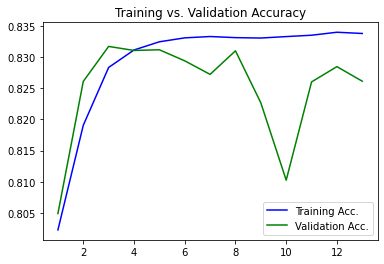

Maximum Validation Accuracy: 0.8316982388496399


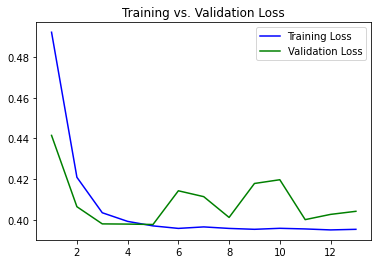

Minimum Validation Loss: 0.3976798951625824


In [ ]:
# Plot training/validation accuracy
acc = history.history['accuracy']
vacc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training Acc.')
plt.plot(epochs, vacc, 'g', label = 'Validation Acc.')
plt.title ('Training vs. Validation Accuracy')
plt.legend()
plt.show()

print('Maximum Validation Accuracy: ' + str(max(history.history['val_accuracy'])))

# Plot training/validation loss
loss = history.history['loss']
vloss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, vloss, 'g', label = 'Validation Loss')
plt.title ('Training vs. Validation Loss')
plt.legend()
plt.show()

print('Minimum Validation Loss: ' + str(min(history.history['val_loss'])))

### Model Evaluation

In [ ]:
# Load Model
trained_model = load_model(path + 'models/WLS_1F_v2.0.hdf5')

In [ ]:
# evaluate on test data (normalized with same parameters as training data)
results = trained_model.evaluate(x = n_xtest, y = ytest, batch_size = 16, verbose = 1)
print('test loss, test acc:', results)

2217/2217 [==============================] - 14s 6ms/step - loss: 0.3924 - accuracy: 0.8359
test loss, test acc: [0.3923698365688324, 0.8358705639839172]


In [ ]:
# # generate predictions on subset of test data (for direct comparison)
# n = 35
# predictions = trained_model.predict(n_xtest[:n])
# print('predictions shape:', predictions.shape)
# print("preds: ", np.around(predictions).reshape(1,n).astype(int)[0])
# print("label: ", ytest[:n])

### Large Model Testing

*   WLS_v1.0 (16APR20)
  *   CONFIG: WLS_BRAVO --> 4xGRU(8), RMSprop (lr = .001), batch size = 16, epochs = 100
  *   SPLIT: 60% train, 20% val, 20% test
  *   vloss, vacc: 0.3494, 0.8539  
  *   tloss, tacc: 0.3422, 0.8534
  *   training time: unknown
*   WLS_v2.0 (29APR20)
  *   CONFIG: WLS_BRAVO --> 4xGRU(8), ReduceLRonPlateau (factor = .01), RMSprop (lr = .001), batch size = 16, epochs = 100
  *   SPLIT: 60% train, 20% val, 20% test
  *   vloss, vacc: 0.3331, 0.8618  
  *   tloss, tacc: 0.3388, 0.8595
  *   training time: 99.7 min
*   WLS_v3.0 (02MAY20)
  *   CONFIG: WLS_GOLF --> 2xGRU(128), ReduceLRonPlateau (factor = .01), RMSprop (lr = .001), batch size = 16, epochs = 100
  *   SPLIT: 60% train, 20% val, 20% test
  *   vloss, vacc: 0.3226, 0.8680  
  *   tloss, tacc: 0.3264, 0.8650
  *   training time: 58.8 min

### Improvements to Try:

*   HARDCODE RANDOM STATE VALUE TO ISOLATE NORMALIZATION PARAMETERS FOR FUTURE EVALUATION - DONE
*   Reduce learning rate on plateau, to address erratic descent - DONE, IMPROVED
*   LSTM - DONE, NO IMPROVEMENT
*   Bidirectional - DONE, NO IMPROVEMENT
*   Taller network - DONE, MINOR IMPROVEMENT, MINOR TRAINING TIME INCREASE
*   Deeper network - DONE, NO IMPROVEMENT, SIGNIFICANT TRAINING TIME INCREASE
*   Taller + Shorter - DONE, MINOR IMPROVEMENT, MINOR TRAINING TIME DECREASE
*   Lower batch size - DONE, VERY MINOR IMPROVEMENT, SIGNIFICANT TRAINING TIME INCREASE
*   Change optimizer - DONE (ADAM), RESULTS EQUAL TO _GOLF, SAME TRAINING TIME, MORE OVERFITTING
*   Adjust learning rate of optimizer - DONE, NO IMPROVEMENT EITHER DIRECTION
*   Implement Dropout (if overfitting) - NOT ATTEMPTED, BROKEN IN GPU RUNTIME, MASSIVE TRAINING TIME INCREASE IN CPU RUNTIME
  
  
### Smaller Model Testing

*   WLS_BRAVO
  *   CONFIG: See above, 20k samples
  *   vloss, vacc: 0.3492, 0.8604
  *   training time: 11.6 min (50 EPOCHS)
*   WLS_CHARLIE
  *   CONFIG: WLS_BRAVO w/ LSTMs
  *   vloss, vacc: 0.3715, 0.8460
  *   training time: 17.5 min
*   WLS_DELTA
  *   CONFIG: WLS_BRAVO w/ Bidirectional
  *   vloss, vacc: 0.3447, 0.8582
  *   training time: 33.3 min
*   WLS_ECHO
  *   CONFIG: 4xGRU(64)
  *   vloss, vacc: 0.3366, 0.8618
  *   training time: 18.3 min
*   WLS_FOXTROT
  *   CONFIG: 8xGRU(8)
  *   vloss, vacc: 0.3594, 0.8562
  *   training time: 41.6 min
*   WLS_GOLF*****
  *   CONFIG: 2xGRU(128)
  *   vloss, vacc: 0.3293, 0.8647
  *   training time: 13.3 min
*   WLS_HOTEL
  *   CONFIG: 2xGRU(128), batch size 16 --> 8
  *   vloss, vacc: 0.3315, 0.8654
  *   training time: 25 min
*   WLS_INDIA
  *   CONFIG: 2xGRU(128), optimizer: adam
  *   vloss, vacc: 0.3301, 0.8646
  *   training time: 13.3 min
*   WLS_JULIET
  *   CONFIG: 2xGRU(128), optimizer learning rate (rmsprop): .01
  *   vloss, vacc: 0.xxxx, 0.xxxx
  *   training time: x min





